In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import re
import sklearn
import nltk
import keras
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
# Helper libraries
import matplotlib.pyplot as plt
import os
import subprocess
import collections
from tensorflow.keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
np.random.seed(1337)  # for reproducibility
from keras.layers import Dense, Dropout, Activation, Lambda,merge,Input,TimeDistributed,Flatten
from keras.models import Sequential
from keras.layers import Embedding, CuDNNLSTM
from keras.layers import Convolution1D, LSTM, Bidirectional
from keras.optimizers import Adadelta
from keras.preprocessing import sequence as sq
from keras.models import Model
from keras.callbacks import ModelCheckpoint

import keras.backend.tensorflow_backend as K

Using TensorFlow backend.


In [17]:
df = pd.read_csv('/train_add_gen.csv', encoding='utf-16')
print(df.shape)
print(df.head(4))

test = pd.read_csv('/content/drive/My Drive/Colab Notebooks (1)/sentiment_analysis/data/test.csv', encoding='utf-16')
print(test.shape)
print(test.head(5))

(10187, 2)
                                             content  ground
0  Đôi khi màn hình chạy chậm...Vào mạng nhanh nó...       0
1  Dùng tốt nhưng thiếu 4g và bộ nhớ hơi kém và m...       0
2  Vào các ứng dụng hầu như rất chậm. Chơi game n...       0
3  Giảm gần 1 nữa lúc mua. F9 ra còn rẻ hơn f7 lú...       0
(1552, 2)
                                             content  ground
0  Sản phẩm hay bị đơ! Dùng pin 4g hao nhanh. Hỗ ...       0
1  Đẹp nhất, cấu hình cao nhất, pin trâu nhất tro...       1
2  Trên cả tuyệt vời 😍 pin trâu, mượt, sang trọng...       1
3  Sản phẩm tầm trung Xài tạm ổn. Nói chung sản p...       0
4  oppo neo 7 thật quá đã. Tính năng cũng như HĐH...       1


In [12]:
df.info

<bound method DataFrame.info of                                           content,ground
0      Đôi khi màn hình chạy chậm...Vào mạng nhanh nó...
1      Dùng tốt nhưng thiếu 4g và bộ nhớ hơi kém và m...
2      Vào các ứng dụng hầu như rất chậm. Chơi game n...
3      Giảm gần 1 nữa lúc mua. F9 ra còn rẻ hơn f7 lú...
4      Đã mua và sử dụng được 2 tháng, rất tuyệt. Xài...
...                                                  ...
10182  mình đã mua và sử dụng điện thoại này rất lâu,...
10183  Nhân viên chu đáo nhiệt tình vui vẻ ^°^ Máy xà...
10184  Mặt lưng sờ rất mượt, cầm trong tay rất thích....
10185  Mua máy bản màu Đỏ được tặng Gậy Selfie và Sạc...
10186  Thiết kế ngoại hình đẹp, cấu hình Ok trong tầm...

[10187 rows x 1 columns]>

In [0]:
def text_normalize(df, tokenize=False):
    # Convert text to lowercase
    df['content'] = df['content'].str.lower()
    # Remove numbers and words with numbers
    df['content'] = df['content'].str.replace('\w*\d\w*', ' ')
    # Remove punctuation
    df['content'] = df['content'].str.replace('[^\w\s]', ' ')
    # Remove whitespaces
    df['content'] =  df['content'].str.split().apply(lambda x : ' '.join(word for word in x))
    # Tokenize
    if tokenize:
        df['content'] = df['content'].apply(lambda x : ViTokenizer.tokenize(x))

In [19]:
text_normalize(df)
text_normalize(test)
test.tail()

,content,ground
1547,máy mình dùng một thời gian ngắn nhưng chậm sử...,0
1548,cho đến hôm nay máy vẫn bị loạn cảm ứng cập nh...,0
1549,đẹp chuẩn sài rất êm tôi rất hài lòng về dòng ...,1
1550,mặc dù mua máy cũ nhưng trông như máy mới mọi ...,1
1551,máy chạy tốt mình hài lòng mua từ tháng năm tớ...,0


In [0]:
X = df['content']
y = df['ground']
X_test = test['content']
y_test = test['ground']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1

In [22]:
maxlen = 0
for x in X_train:
    if maxlen < len(x):
        maxlen = len(x)
maxlen

464

In [0]:
# set parameters:
max_features = 21540#14300
maxlen = 400
batch_size = 10
embedding_dims = 200
nb_filter = 150
filter_length = 3
hidden_dims = 100
nb_epoch = 3
accs = []

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

8326 train sequences
1559 test sequences


In [0]:
X_train = sq.pad_sequences(X_train, maxlen=maxlen)
print('X_train shape:', X_train.shape)
X_test = sq.pad_sequences(X_test, maxlen=maxlen)
print('X_test shape:', X_test.shape)
X_val = sq.pad_sequences(X_val, maxlen=maxlen)
print('X_val shape:', X_val.shape)

X_train shape: (8326, 400)
X_test shape: (1559, 400)
X_val shape: (2082, 400)


# LSTM + CNN
https://github.com/ntienhuy/MultiChannel

In [0]:
model = Sequential()

input_layer = Input(shape=(maxlen,),dtype='int32', name='main_input')
emb_layer = Embedding(max_features, embedding_dims, input_length=maxlen)(input_layer)

In [0]:
def max_1d(X):
    return K.max(X, axis=1)

In [0]:
# we add a Convolution1D, which will learn nb_filter
# word group filters of size 3:

con3_layer = Convolution1D(nb_filter=nb_filter,filter_length=3,  border_mode='valid',  activation='relu', subsample_length=1)(emb_layer)
pool_con3_layer = Lambda(max_1d, output_shape=(nb_filter,))(con3_layer)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=150, kernel_size=3, strides=1, padding="valid")`
  


In [0]:
# we add a Convolution1D, which will learn nb_filter
# word group filters of size 4:
con4_layer = Convolution1D(nb_filter=nb_filter,filter_length=5, border_mode='valid',activation='relu', subsample_length=1)(emb_layer)
pool_con4_layer = Lambda(max_1d, output_shape=(nb_filter,))(con4_layer)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=150, kernel_size=5, strides=1, padding="valid")`
  """Entry point for launching an IPython kernel.


In [0]:
# we add a Convolution1D, which will learn nb_filter
# word group filters of size 5:
con5_layer = Convolution1D(nb_filter=nb_filter,filter_length=7,  border_mode='valid', activation='relu', subsample_length=1)(emb_layer)
pool_con5_layer = Lambda(max_1d, output_shape=(nb_filter,))(con5_layer)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=150, kernel_size=7, strides=1, padding="valid")`
  """Entry point for launching an IPython kernel.


In [0]:
#from keras.layers import merge
#cnn_layer = merge([pool_con3_layer, pool_con5_layer,pool_con4_layer], mode='concat')
from keras.layers import add, concatenate
cnn_layer = concatenate([pool_con3_layer, pool_con5_layer,pool_con4_layer])
cnn_layer

<tf.Tensor 'concatenate_3/concat:0' shape=(?, 450) dtype=float32>

In [0]:
#LSTM
x = Embedding(max_features, embedding_dims, input_length=maxlen)(input_layer)
lstm_layer = LSTM(128)(x)

cnn_lstm_layer = concatenate([lstm_layer, cnn_layer])
cnn_lstm_layer

<tf.Tensor 'concatenate_4/concat:0' shape=(?, 578) dtype=float32>

In [0]:
dense_layer = Dense(hidden_dims*2, activation='sigmoid')(cnn_lstm_layer)
output_layer= Dropout(0.2)(dense_layer)
output_layer = Dense(1, trainable=True,activation='softmax')(output_layer)

model = Model(input=[input_layer], output=[output_layer])
adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=1e-06)

model.compile(loss='binary_crossentropy', optimizer="adamax", metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  """


In [0]:
#save model every
checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5',monitor='val_acc', verbose=0, save_best_only=True, mode='max')

In [0]:
#model.fit(X_train, y_train,batch_size=batch_size,epochs=nb_epoch,callbacks=[checkpoint],validation_data=(X_val, y_val))
history =model.fit(X_train, y_train,batch_size=batch_size,epochs=nb_epoch,callbacks=[checkpoint],validation_data=(X_val, y_val))

Train on 8326 samples, validate on 2082 samples
Epoch 1/3
8326/8326 [==============================] - 705s 85ms/step - loss: 7.9520 - acc: 0.5012 - val_loss: 8.0478 - val_acc: 0.4952
Epoch 2/3
8326/8326 [==============================] - 687s 83ms/step - loss: 7.9520 - acc: 0.5012 - val_loss: 8.0478 - val_acc: 0.4952
Epoch 3/3
8326/8326 [==============================] - 694s 83ms/step - loss: 7.9520 - acc: 0.5012 - val_loss: 8.0478 - val_acc: 0.4952


In [0]:
#model.load_weights('weights.{epoch:02d}-{val_loss:.2f}.hdf5')
model.compile(loss='binary_crossentropy', optimizer="adamax", metrics=['accuracy'])
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print("Acc:", acc)
accs.append(acc)

1559/1559 [==============================] - 51s 33ms/step
Acc: 0.5099422782468368


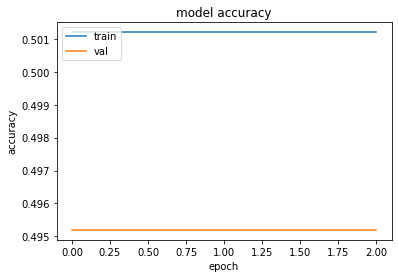

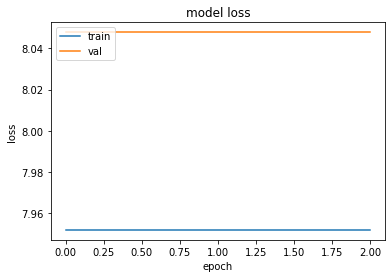

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

# LSTM

https://www.kaggle.com/ngyptr/lstm-sentiment-analysis-keras

In [0]:
embed_dim = 128
lstm_out = 196
max_fatures =1000

model1 = Sequential()
model1.add(Embedding(max_fatures, embed_dim,input_length = maxlen))
model1.add(SpatialDropout1D(0.4))
model1.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(1,activation='softmax'))
model1.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 400, 200)     4308000     main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 398, 150)     90150       embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 394, 150)     210150      embedding_3[0][0]                
____________________________________________________________________________________________

In [0]:
batch_size = 32
history = model1.fit(X_train, y_train, epochs = 7, batch_size=batch_size, verbose = 2, validation_data=(X_val, y_val))

Train on 8326 samples, validate on 2082 samples
Epoch 1/7
 - 248s - loss: 7.9520 - acc: 0.5012 - val_loss: 8.0478 - val_acc: 0.4952
Epoch 2/7
 - 246s - loss: 7.9520 - acc: 0.5012 - val_loss: 8.0478 - val_acc: 0.4952
Epoch 3/7
 - 247s - loss: 7.9520 - acc: 0.5012 - val_loss: 8.0478 - val_acc: 0.4952
Epoch 4/7
 - 246s - loss: 7.9520 - acc: 0.5012 - val_loss: 8.0478 - val_acc: 0.4952
Epoch 5/7
 - 246s - loss: 7.9520 - acc: 0.5012 - val_loss: 8.0478 - val_acc: 0.4952
Epoch 6/7
 - 245s - loss: 7.9520 - acc: 0.5012 - val_loss: 8.0478 - val_acc: 0.4952
Epoch 7/7
 - 246s - loss: 7.9520 - acc: 0.5012 - val_loss: 8.0478 - val_acc: 0.4952


In [0]:
score,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 7.81
acc: 0.51


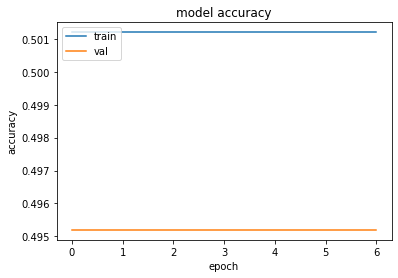

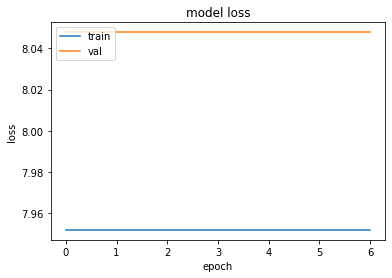

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

# LSTM with attention
https://www.kaggle.com/ahogrammer/attention-based-lstm

In [0]:
EMBEDDING_FILE =  '/content/drive/My Drive/Colab Notebooks (1)/sentiment_analysis/resource/cc.vi.300.vec'

def load_embeddings(filename):
    embeddings = {}
    with open(filename) as f:
        for line in f:
            values = line.rstrip().split(' ')
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

embeddings = load_embeddings(EMBEDDING_FILE)

In [0]:
from keras.preprocessing import text, sequence

In [26]:
def filter_embeddings(embeddings, word_index, vocab_size, dim=300):
    embedding_matrix = np.zeros([vocab_size, dim])
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        vector = embeddings.get(word)
        if vector is not None:
            embedding_matrix[i] = vector
    return embedding_matrix

embedding_size = 300
embedding_matrix = filter_embeddings(embeddings, tokenizer.word_index,
                                     vocab_size, embedding_size)
print('OOV: {}'.format(len(set(tokenizer.word_index) - set(embeddings))))

OOV: 415


In [0]:
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
class Attention(Layer):
    """
    Keras Layer that implements an Attention mechanism for temporal data.
    Supports Masking.
    Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    :param kwargs:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(Attention())
    """
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [0]:
embedding_size = 300
def filter_embeddings(embeddings, word_index, vocab_size, dim=300):
    embedding_matrix = np.zeros([vocab_size, dim])
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        vector = embeddings.get(word)
        if vector is not None:
            embedding_matrix[i] = vector
    return embedding_matrix
    
embedding_matrix = filter_embeddings(embeddings, tokenizer.word_index,vocab_size, embedding_size)

def build_model(maxlen, vocab_size, embedding_size, embedding_matrix):
    input_words = Input((maxlen, ))
    x_words = Embedding(vocab_size,
                        embedding_size,
                        weights=[embedding_matrix],
                        mask_zero=True,
                        trainable=False)(input_words)
    x_words = SpatialDropout1D(0.3)(x_words)
    x_words = Bidirectional(LSTM(50, return_sequences=True))(x_words)
    x = Attention(maxlen)(x_words)
    x = Dropout(0.2)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.2)(x)
    pred = Dense(5, activation='softmax')(x)

    model = Model(inputs=input_words, outputs=pred)
    return model

In [29]:
model = build_model(maxlen, vocab_size, embedding_size, embedding_matrix)
model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 464)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 464, 300)          1716900   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 464, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 464, 100)          140400    
_________________________________________________________________
attention_1 (Attention)      (None, 100)               564       
____________________________________

In [30]:
history = model.fit(X_train, y_train, epochs=100, verbose=1,batch_size=1024, shuffle=True,  validation_data=(X_val, y_val))

ValueError: ignored

In [0]:
score,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = 1024)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.37
acc: 0.87


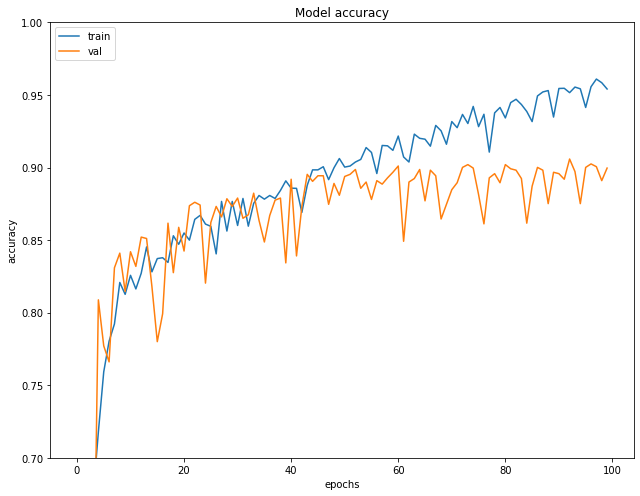

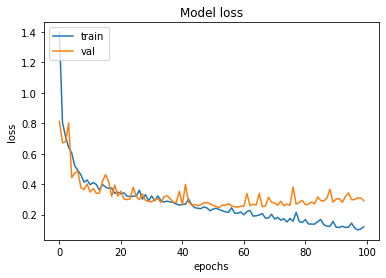

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=[9,7])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.ylim((0.7,1))
plt.xlabel('epochs')
plt.legend(['train','val'], loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [0]:
from keras.utils.visualize_utils import plot


ModuleNotFoundError: ignored

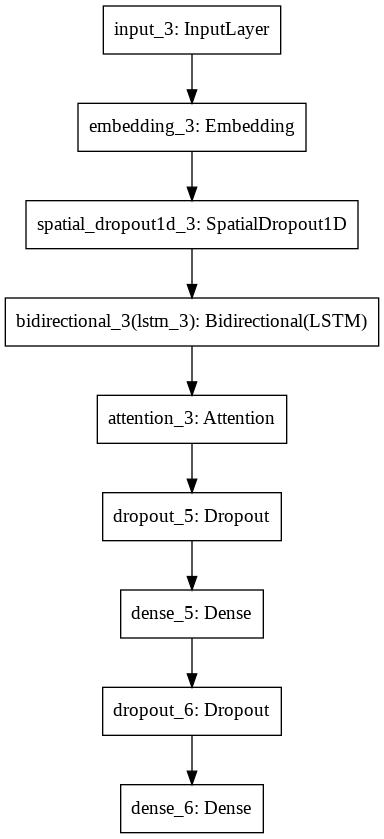

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')